In [25]:
path = r"C:\Users\PC0\Documents\bovine disease__pfe benzaouche_harbane\FMD_Cattle"

In [43]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#This tells PIL:
#"If image is slightly broken, load what you can."

In [26]:
import os
from pathlib import Path

dataset_path = Path(path)  # path returned by kagglehub
print("Dataset root:", dataset_path)
print("\nDirectory structure:")
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(str(dataset_path), '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/ ({len(files)} files)")

Dataset root: C:\Users\PC0\Documents\bovine disease__pfe benzaouche_harbane\FMD_Cattle

Directory structure:
FMD_Cattle/ (0 files)
  0/ (200 files)
  1/ (174 files)


In [27]:
from collections import defaultdict

class_counts = defaultdict(int)

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg")):
            class_name = os.path.basename(root)
            class_counts[class_name] += 1

class_counts


defaultdict(int, {'0': 200, '1': 174})

In [28]:
from PIL import Image
import os

dataset_path = "FMD_Cattle/FMD_Cattle"

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith((".jpg", ".png", ".jpeg")):
            path = os.path.join(root, file)
            try:
                with Image.open(path) as img:
                    img.verify()
            except Exception:
                print("Removing corrupted:", path)
                os.remove(path)

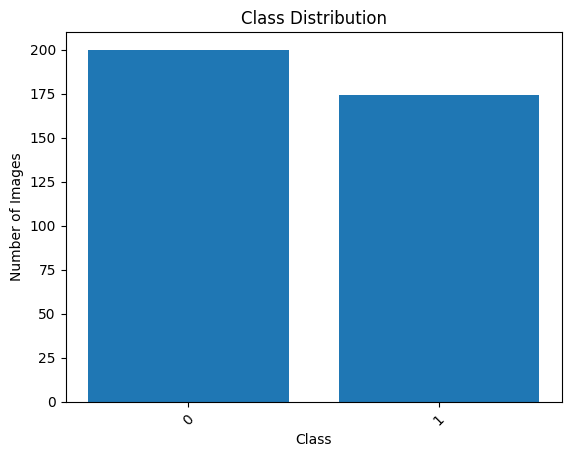

In [29]:
import matplotlib.pyplot as plt

labels = list(class_counts.keys())
values = list(class_counts.values())

plt.bar(labels, values)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

In [31]:
from PIL import Image
import numpy as np

image_sizes = []

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg")):
            img_path = os.path.join(root, file)
            img = Image.open(img_path)
            image_sizes.append(img.size)  # (width, height)

# Convert to numpy
image_sizes = np.array(image_sizes)

print("Average size:", image_sizes.mean(axis=0))
print("Min size:", image_sizes.min(axis=0))
print("Max size:", image_sizes.max(axis=0))

Average size: [3499.86898396 2649.5828877 ]
Min size: [379 266]
Max size: [8718 6240]


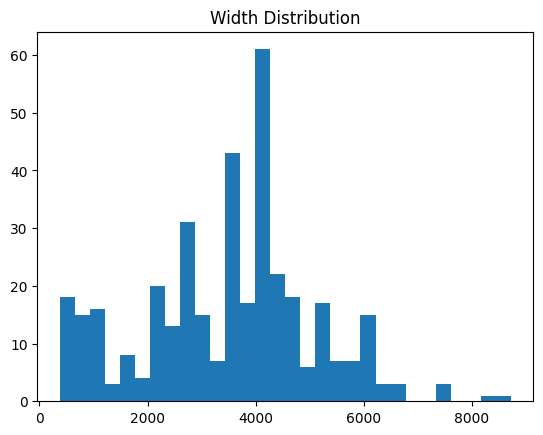

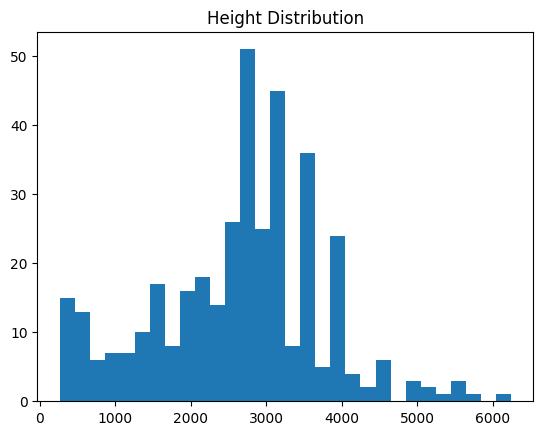

In [32]:
plt.hist(image_sizes[:,0], bins=30)
plt.title("Width Distribution")
plt.show()

plt.hist(image_sizes[:,1], bins=30)
plt.title("Height Distribution")
plt.show()

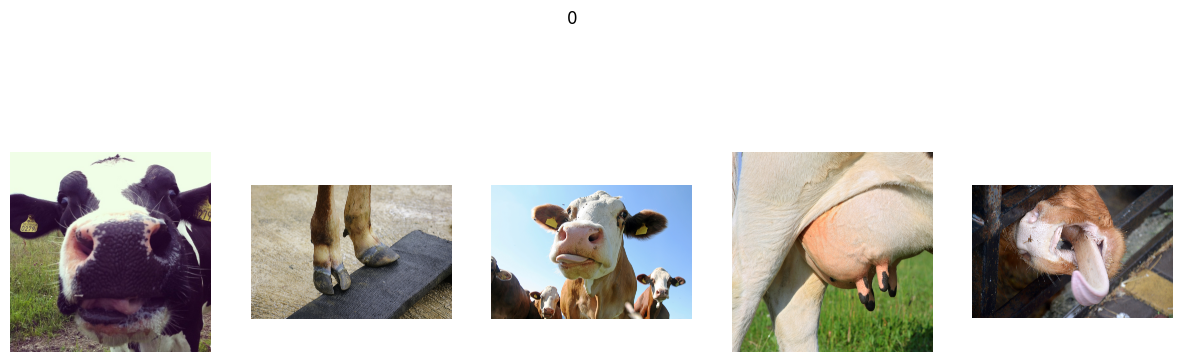

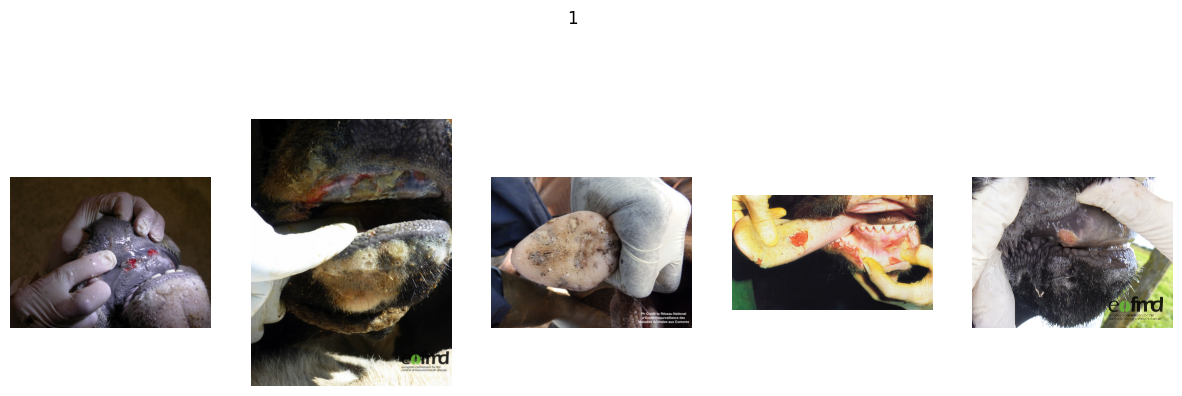

In [34]:
import random
import matplotlib.pyplot as plt

def show_samples(class_name, num_samples=5):
    class_path = os.path.join(path, class_name)
    images = os.listdir(class_path)
    samples = random.sample(images, num_samples)
    
    plt.figure(figsize=(15,5))
    for i, img_name in enumerate(samples):
        img = Image.open(os.path.join(class_path, img_name))
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(class_name)
    plt.show()

# Example:
for class_name in class_counts.keys():
    show_samples(class_name)


In [35]:
import hashlib

hashes = {}
duplicates = []

for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith((".jpg",".png",".jpeg")):
            img_path = os.path.join(root, file)
            with open(img_path, "rb") as f:
                filehash = hashlib.md5(f.read()).hexdigest()
            
            if filehash in hashes:
                duplicates.append(img_path)
            else:
                hashes[filehash] = img_path

print("Duplicate images found:", len(duplicates))


Duplicate images found: 5


In [36]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])


In [37]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

dataset = ImageFolder(root=path, transform=train_transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [38]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet50(pretrained=True)

# Freeze backbone (important for small dataset)
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
model.fc = nn.Linear(model.fc.in_features, 2)

model = model.cuda()


c:\Users\PC0\Documents\bovine disease__pfe benzaouche_harbane\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC0\Documents\bovine disease__pfe benzaouche_harbane\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)                                                             
                                                         

In [40]:
import torch

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    return correct


In [44]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

for epoch in range(num_epochs):
    
    # ===== TRAINING =====
    model.train()
    train_loss = 0
    train_correct = 0
    total_train = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += calculate_accuracy(outputs, labels)
        total_train += labels.size(0)
    
    train_accuracy = 100 * train_correct / total_train
    
    
    # ===== VALIDATION =====
    model.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_correct += calculate_accuracy(outputs, labels)
            total_val += labels.size(0)
    
    val_accuracy = 100 * val_correct / total_val
    
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    print("-" * 40)


Epoch [1/20]
Train Accuracy: 51.51%
Validation Accuracy: 60.00%
----------------------------------------
Epoch [2/20]
Train Accuracy: 69.90%
Validation Accuracy: 82.67%
----------------------------------------
Epoch [3/20]
Train Accuracy: 89.30%
Validation Accuracy: 82.67%
----------------------------------------
Epoch [4/20]
Train Accuracy: 85.95%
Validation Accuracy: 86.67%
----------------------------------------
Epoch [5/20]
Train Accuracy: 88.96%
Validation Accuracy: 88.00%
----------------------------------------
Epoch [6/20]
Train Accuracy: 89.30%
Validation Accuracy: 86.67%
----------------------------------------
Epoch [7/20]
Train Accuracy: 93.31%
Validation Accuracy: 89.33%
----------------------------------------
Epoch [8/20]
Train Accuracy: 93.31%
Validation Accuracy: 88.00%
----------------------------------------


KeyboardInterrupt: 

In [45]:
torch.save(model.state_dict(), "best_model.pth")

In [46]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


[[39  3]
 [ 6 27]]


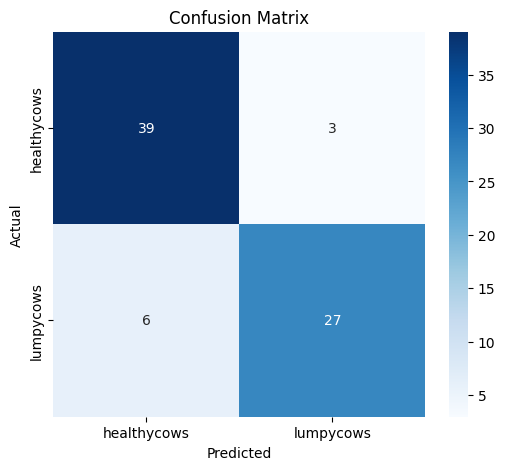

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)
print(cm)
class_names = ["healthycows", "lumpycows"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


early stop to prevent overfitting 